*Importing Libraries*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import random
from tqdm import tqdm
np.random.seed(42)
random.seed(42)

*Question 1*
- *Apply Kmeans on Old faithful*
- *Plot the Clustering result with different colors*

*Fetching the dataset*

In [ ]:
os.environ["KAGGLE_USERNAME"] = "nidamanuriadarsh"
os.environ["KAGGLE_KEY"] = "c9c25d39a13d0a11ba5b82ca1dd4119a"
!kaggle datasets download -d janithwanni/old-faithful
!unzip old-faithful.zip

old-faithful.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  old-faithful.zip
replace faithful.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


*Kmeans Algorithm*

In [ ]:
class KMeans:
    def __init__(self, data, centroids, threshold=1e-4, random_seed=42):
        self.data = data
        self.no_of_centroids = centroids
        random_indices = np.random.choice(range(len(data)), centroids, replace=False)
        self.centroids = data[random_indices]
        self.losses = []
        self.threshold = threshold
        self.loss = None
        self.cluster_assignments = None

    def return_centroids(self):
        return self.centroids

    def loss_plot(self):
        plt.figure(figsize=(6, 4))
        plt.plot(self.losses, marker='o', linestyle='-')
        plt.title('Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_clusters(self):
        if self.cluster_assignments is None:
            print("Clusters not assigned. Please train the model first.")
            return

        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

        for i in range(self.no_of_centroids):
            cluster_points = np.array([self.data[j] for j in range(len(self.data)) if self.cluster_assignments[j] == i])
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i + 1}')

        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker='X', label='Centroids')
        plt.title('Data Points and Centroids')
        plt.xlabel('Eruptions')
        plt.ylabel('Waiting')
        plt.legend()
        plt.show()

    def train(self):
        while True:
            centers = np.zeros((self.no_of_centroids, len(self.data[0])))
            counts = np.zeros(self.no_of_centroids)
            temp_centroids = self.centroids.copy()
            total_distance = 0
            cluster_assignments = []

            for i in self.data:
                arg_dist = -1
                min_dist = 1e9

                for j in range(len(self.centroids)):
                    dist = np.linalg.norm(np.array(i) - np.array(self.centroids[j]))

                    if dist < min_dist:
                        min_dist = dist
                        arg_dist = j

                centers[arg_dist] += i
                counts[arg_dist] += 1
                total_distance += (min_dist ** 0.5)
                cluster_assignments.append(arg_dist)

            for i in range(len(centers)):
                centers[i] = centers[i] / counts[i]

            self.centroids = centers
            self.losses.append(total_distance / len(self.data))
            self.loss = total_distance / len(self.data)
            self.cluster_assignments = np.array(cluster_assignments)

            if np.sum((np.sum((self.centroids - temp_centroids) ** 2, axis=1)) ** 0.5) < self.threshold:
                break


*Applying Kmeans on Old-Faithful*

In [ ]:
df = pd.read_csv("old-faithful.zip")
df = df[["eruptions","waiting"]]
model = KMeans(df.to_numpy(),2,threshold=1e-4)
model.train()

*plot of losses over epochs*

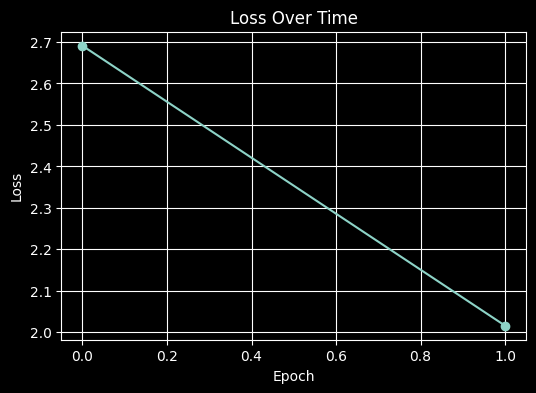

In [ ]:
model.loss_plot()

*scatterplot of clustering result*

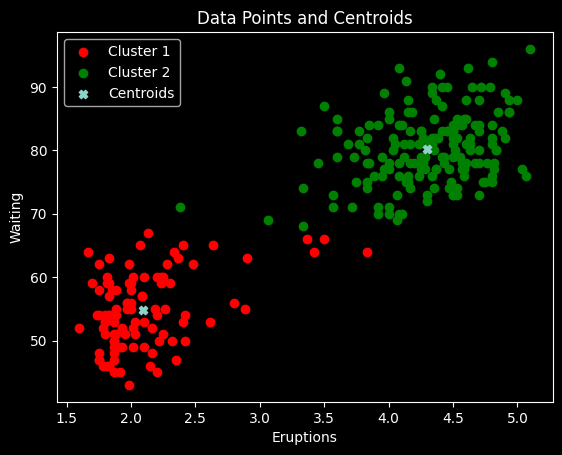

In [ ]:
model.plot_clusters()

*Question 2*
- *Sample the multivariate Gaussian Distribution*
- *Plot the Contours*
- *Apply Clusterization using original parameters theta*
- *Plot the Clustering result*

In [ ]:
class GMM:
  def __init__(self,noofclusters,means,covariances,noofpoints=[1000,1000,1000]):
    self.noofclusters = noofclusters
    self.means = means
    self.covariances = covariances
    self.samples = None
    self.noofpoints = noofpoints
    self.invertedcovariances = None
    self.shuffled_points = None
    self.cluster_assignments = None
  def inverse_2x2(self,matrix):
    a, b, c, d = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]
    determinant = a*d - b*c
    inverse_matrix = (1 / determinant) * np.array([[d, -b], [-c, a]])
    return inverse_matrix
  def get_pdf(self,points,inv_matrix,mean):
    a, b, c, d = inv_matrix[0][0], inv_matrix[0][1], inv_matrix[1][0], inv_matrix[1][1]
    determinant = a*d - b*c
    denominator = 1/(2*math.pi*((determinant)**0.5))
    numerator = np.exp(-0.5 * np.sum((points - mean).dot(inv_matrix) * (points - mean), axis=1))
    z = numerator*denominator
    return z

  def generate_distribution(self):
    samples = []
    invertedcovariances = []
    shuffled_points = []
    temp = 0
    samples1 = []
    for i in range(self.noofclusters):
      tempsamples = np.random.multivariate_normal(self.means[i],self.covariances[i],self.noofpoints[i])
      shuffled_points.append(tempsamples)
      tempmean = np.tile(self.means[i],(len(tempsamples),1))
      inverted = self.inverse_2x2(self.covariances[i])
      invertedcovariances.append(inverted)
      a, b, c, d = inverted[0][0], inverted[0][1], inverted[1][0], inverted[1][1]
      determinant = a*d - b*c
      denominator = 1/(2*math.pi*((determinant)**0.5))
      numerator = np.exp(-0.5 * np.sum((tempsamples - self.means[i]).dot(inverted) * (tempsamples - self.means[i]), axis=1))
      z = numerator*denominator
      final = np.dstack((np.array([tempsamples]),z))[0]
      samples1.append(final)
      if temp==0:
        samples=tempsamples
      else:
        samples=np.concatenate((samples,tempsamples),axis=0)
      temp+=1
    samples = np.array(samples)
    self.shuffled_points = np.random.permutation(samples)
    self.samples = samples1
    self.invertedcovariances = invertedcovariances
    return samples
  def contours(self):
    plt.style.use("dark_background")
    plt.figure(figsize=(6, 4))
    plt.title("Countours of Generated Distribution")
    for i in range(self.noofclusters):
      plt.tricontour(self.samples[i][:, 0],self.samples[i][:, 1],self.samples[i][:, 2], levels=10,cmap="magma")
    plt.show()
  def clusterify(self):
    distances_fin = []
    for i in range(self.noofclusters):
        inv_covariance = self.invertedcovariances[i]
        centered_points = self.shuffled_points - self.means[i]
        distances = np.sum(centered_points.dot(inv_covariance) * centered_points, axis=1)
        distances_fin.append(distances)
    distances_fin = np.array(distances_fin).T
    cluster_assignments = np.argmin(distances_fin,axis=1)
    self.cluster_assignments = cluster_assignments
    return cluster_assignments
  def plot_clusters(self):
    plt.style.use("dark_background")
    plt.figure(figsize=(6,4))
    for i in range(self.noofclusters):
        plt.scatter(self.shuffled_points[self.cluster_assignments == i, 0],
                    self.shuffled_points[self.cluster_assignments == i, 1],
                    label=f'Cluster {i + 1}', cmap='viridis', marker='o')
    plt.title("Scatter Plot of Clusters")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()

In [ ]:
distributor = GMM(3,[[0,12],[9,16],[9,7]],[[[1,0],[0,6]],[[4,0],[0,2]],[[4,2],[2,3]]],[10000,6000,14000])

*Generating the distribution*

In [ ]:
distributor.generate_distribution().shape

(30000, 2)

*plotting contours*

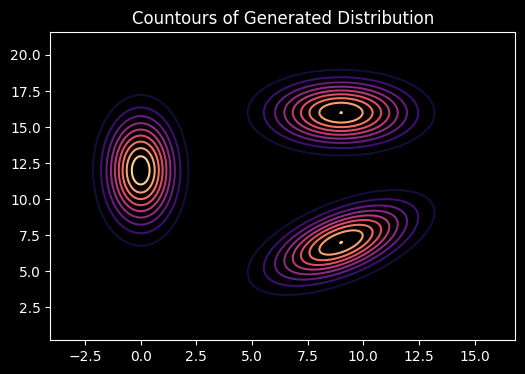

In [ ]:
distributor.contours()

*performing clusterization*

In [ ]:
distributor.clusterify()

array([0, 0, 0, ..., 2, 2, 0])

*plotting the result*

<ipython-input-310-70d95a19d8ef>:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(self.shuffled_points[self.cluster_assignments == i, 0],


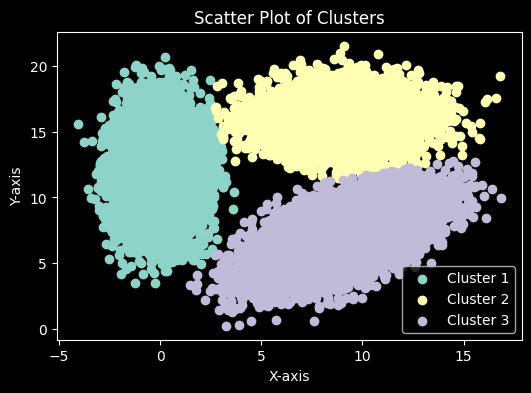

In [ ]:
distributor.plot_clusters()

*Applying Kmeans on generated data*

In [ ]:
initiator = KMeans(distributor.shuffled_points,3,threshold=1e-4)
initiator.train()

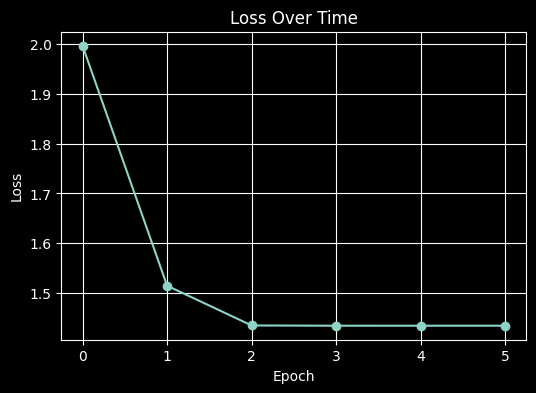

In [ ]:
initiator.loss_plot()

*As you can see the prediction of kmeans in not much accurate as kmeans assumes spherical distributions but our initial distribution is multivariate gaussian(ellipsoid)*

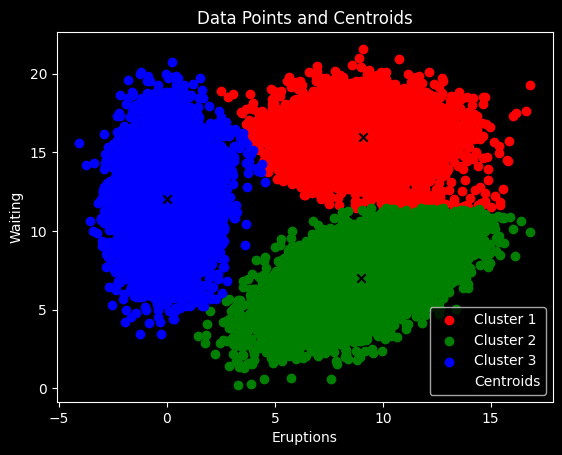

In [ ]:
initiator.plot_clusters()

*EM Algorithm*

In [ ]:
class EMAlgo(GMM):
  def __init__(self,initial_params,noofclusters,means,covariances,noofpoints=[1000,1000,1000],max_iter=10000,threshold=1e-10):
    self.initial_params = initial_params
    super().__init__(noofclusters,means,covariances,noofpoints)
    self.covparams = np.array([np.eye(2) for _ in range(noofclusters)])
    self.pis = np.random.rand(noofclusters)
    self.pis = self.pis/np.sum(self.pis)
    self.max_iter = max_iter
    self.threshold = threshold
    self.log_likelihood_values = None
    self.cluster_assignmentsres = None
  def Estep(self):
    gammas = np.zeros((len(self.shuffled_points),self.noofclusters))
    for i in range(self.noofclusters):
        gammas[:, i] = self.pis[i] * self.get_pdf(self.shuffled_points,self.inverse_2x2(self.covparams[i]),self.initial_params[i])
    gammas = gammas / np.sum(gammas, axis=1, keepdims=True)
    return gammas
  def Mstep(self,gammas):
    Nk = np.sum(gammas, axis=0)
    means = np.dot(gammas.T, self.shuffled_points) / Nk[:, None]
    covs = np.zeros((self.noofclusters,2,2))
    for i in range(self.noofclusters):
        diff = self.shuffled_points - means[i]
        cov_sum = np.zeros((2,2))
        for j in range(len(self.shuffled_points)):
            cov_sum += gammas[j, i] * (diff[j].reshape(-1, 1) @ diff[j].reshape(1, -1))
        covs[i] = cov_sum / Nk[i]
    pis = Nk / len(self.shuffled_points)
    return means, covs, pis
  def log_likelihood(self,data, means, covariances, weights, gamma):
    num_samples = len(data)
    num_components = len(means)
    log_likelihood_value = 0.0
    for i in range(num_samples):
        for j in range(num_components):
            pdf_value = self.get_pdf([data[i]], self.inverse_2x2(covariances[j]) ,means[j])[0]
            log_likelihood_value += gamma[i][j] * (np.log(weights[j]) + np.log(pdf_value) - np.log(gamma[i][j]))
    return log_likelihood_value
  def applyalgo(self):
    prev_parameters = (self.initial_params.copy(), self.covparams.copy(), self.pis.copy())
    self.log_likelihood_values = []
    for i in tqdm(range(self.max_iter)):
        gammas = self.Estep()
        means, covs, pis = self.Mstep(gammas)
        self.log_likelihood_values.append(self.log_likelihood(self.shuffled_points, self.initial_params, self.covparams, self.pis, gammas))
        if sum(np.linalg.norm(old_param - new_param) for old_param, new_param in zip(prev_parameters, (means,covs,pis)))< self.threshold:
            break
        self.initial_params,self.covparams,self.pis = (means,covs,pis)
        prev_parameters = (means.copy(), covs.copy(), pis.copy())
    return
  def plot_likelihoods(self):
    plt.style.use("dark_background")
    plt.figure(figsize=(6,4))
    plt.plot(self.log_likelihood_values, label='Log Likelihood')
    plt.title('Log Likelihood Convergence')
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.legend()
    plt.grid(True)
    plt.show()
  def modelsummary(self):
    print("=============================================")
    print("The evaluated Means are:")
    print(self.initial_params)
    print("=============================================")
    print("The evaluated Covariances are:")
    print(self.covparams)
    print("=============================================")
    print("The evaluated pis are:")
    print(self.pis)
    print("=============================================")
  def clusterifyres(self):
    distances_fin = []
    for i in range(self.noofclusters):
        inv_covariance = self.inverse_2x2(self.covparams[i])
        centered_points = self.shuffled_points - self.initial_params[i]
        distances = np.sum(centered_points.dot(inv_covariance) * centered_points, axis=1)
        distances_fin.append(distances)
    distances_fin = np.array(distances_fin).T
    cluster_assignments = np.argmin(distances_fin,axis=1)
    self.cluster_assignmentsres = cluster_assignments
    return cluster_assignments
  def plot_clustersres(self):
    plt.style.use("dark_background")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(self.noofclusters):
        axes[0].scatter(self.shuffled_points[self.cluster_assignments == i, 0],
                        self.shuffled_points[self.cluster_assignments == i, 1],
                        label=f'Cluster {i + 1}', cmap='viridis', marker='o')
    axes[0].set_title("Scatter Plot of Clusters Original Params")
    axes[0].set_xlabel("X-axis")
    axes[0].set_ylabel("Y-axis")
    axes[0].legend()
    for i in range(self.noofclusters):
        axes[1].scatter(self.shuffled_points[self.cluster_assignmentsres == i, 0],
                        self.shuffled_points[self.cluster_assignmentsres == i, 1],
                        label=f'Cluster {i + 1}', cmap='viridis', marker='o')
    axes[1].set_title("Scatter Plot of Clusters EMAlgo")
    axes[1].set_xlabel("X-axis")
    axes[1].set_ylabel("Y-axis")
    axes[1].legend()
    plt.tight_layout()
    plt.show()




*Initializing our previous distribution*

In [ ]:
expecto_maximizer = EMAlgo(np.array(initiator.return_centroids()),3,[[0,12],[9,16],[9,7]],[[[1,0],[0,6]],[[4,0],[0,2]],[[4,2],[2,3]]],[10000,6000,14000],1000,1e-10)

*Applying EM algorithm and then Clusterifying the result*

In [ ]:
expecto_maximizer.generate_distribution()
expecto_maximizer.clusterify()
expecto_maximizer.applyalgo()
expecto_maximizer.clusterifyres()

  2%|▏         | 15/1000 [00:54<59:27,  3.62s/it]


array([1, 1, 1, ..., 2, 1, 1])

*Plotting the log likelihoods vs iterations*

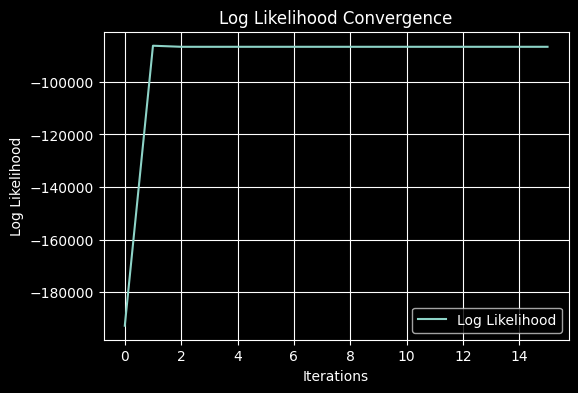

In [ ]:
expecto_maximizer.plot_likelihoods()

*Checking whether the predicted estimates are correct or not*

In [ ]:
expecto_maximizer.modelsummary()

The evaluated Means are:
[[ 8.98901314e+00  1.59908700e+01]
 [ 8.98906293e+00  6.98918907e+00]
 [-1.54520887e-02  1.20547548e+01]]
The evaluated Covariances are:
[[[4.02474781 0.05070043]
  [0.05070043 1.99201371]]

 [[3.97248848 1.97456095]
  [1.97456095 3.0039083 ]]

 [[0.98060794 0.0482052 ]
  [0.0482052  5.9804525 ]]]
The evaluated pis are:
[0.19999576 0.46690373 0.33310051]


*Visually checking whether the clustering is accurate or not*

<ipython-input-319-3a61f592c0a9>:87: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(self.shuffled_points[self.cluster_assignments == i, 0],
<ipython-input-319-3a61f592c0a9>:95: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(self.shuffled_points[self.cluster_assignmentsres == i, 0],


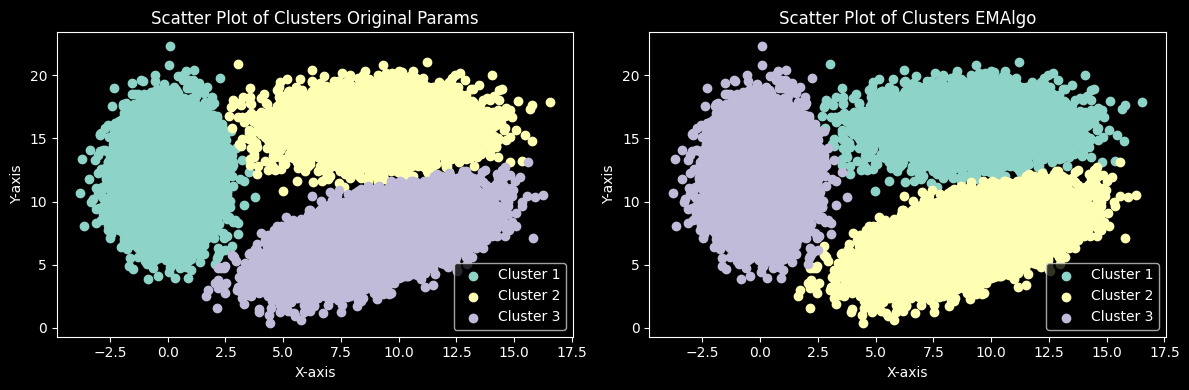

In [ ]:
expecto_maximizer.plot_clustersres()